## SFR with Mass Ratio
Here, we are looking for any relation with mass ratio to star fomration rate. Found from my subsample of galaxy pairs.

### Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import sys
import cv2 as cv
from tqdm import tqdm
tqdm.pandas()

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u

In [2]:
combine_fold = 'C:/Users/oryan/Documents/mergers-in-cosmos/cats-to-combine'
data_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/back-to-basics-data'
fig_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/paper-source/figures'
cos_dat_fold = 'E:/cosmos-data'

### Importing My Data

In [4]:
df_cat = pd.read_csv(f'{combine_fold}/dor-all-restaged-full.csv', index_col = 0)

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
df_cat.head()

,ORyanID_23,ID,category,ALPHA_J2000,DELTA_J2000,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,...,ez_ssfr_p025,ez_ssfr_p160,ez_ssfr_p500,ez_ssfr_p840,ez_ssfr_p975,ez_Av_p025,ez_Av_p160,ez_Av_p500,ez_Av_p840,ez_Av_p975
0,4000705532455,816891,stage4,150.679846,2.196543,9200.399414,21737.232422,0.000052,0.000059,-0.000010,...,-8.931825,-8.911355,-8.899668,-8.883307,-8.872990,0.529107,0.560142,0.599624,0.630920,0.652330
1,4000705533383,860686,stage3,150.644522,2.237226,10047.978516,22713.351562,0.000051,0.000046,0.000002,...,-9.314209,-9.106611,-8.941274,-8.713107,-8.541205,0.341270,0.545498,0.732327,0.906665,1.020098
2,4000705539941,1301188,stage2,149.702462,2.654895,32637.949219,32737.013672,0.000064,0.000104,-0.000003,...,-9.794128,-9.784252,-9.766013,-9.743796,-9.727879,0.018737,0.018737,0.018737,0.018737,0.018737
3,4000705540034,1304538,stage3,149.726828,2.658172,32053.712891,32815.468750,0.000071,0.000086,-0.000006,...,-9.480532,-9.443615,-9.402433,-9.352081,-9.325659,0.302629,0.376027,0.440394,0.508153,0.567727
4,4000705540064,1310001,stage3,149.701230,2.660343,32667.441406,32867.789062,0.000026,0.000020,-0.000010,...,-9.882174,-9.855921,-9.816085,-9.697225,-9.573506,0.455258,0.482555,0.522239,0.600383,0.660279


In [6]:
df_red_tmp = df_cat.query('ez_sfr < 10')
df_red = df_red_tmp.query('lp_mass_best > 6.5')

### Reducing DataFrame

In [8]:
df_ra_dec = (
    df_red
    [['ORyanID_23', 'ID', 'category', 'ALPHA_J2000', 'DELTA_J2000', 'ez_z_phot', 'lp_zBEST', 'lp_mass_best', 'ez_sfr']]
)

In [9]:
def getting_duplicates(id_str, df):
    check = len(df.query('ORyanID_23 == @id_str'))
    if check > 1.5:
        return 'y'
    else:
        return 'n'

In [10]:
def picking_z(ez_z, lp_z):
    if np.isnan(ez_z):
        if not np.isnan(lp_z):
            return lp_z
        else:
            return np.nan
    
    if np.isnan(lp_z):
        if not np.isnan(ez_z):
            return ez_z
        else:
            return np.nan
    
    if lp_z < ez_z:
        return lp_z
    elif ez_z <= lp_z:
        return ez_z
    else:
        return 'what'

### Finding Duplicates

In [11]:
df_checked = (
    df_ra_dec
    .assign(coords = df_ra_dec.apply(lambda row: SkyCoord(ra = row.ALPHA_J2000 * u.deg, dec = row.DELTA_J2000 * u.deg, frame = 'fk5'), axis = 1))
    .assign(filt = df_ra_dec.ORyanID_23.apply(lambda x: getting_duplicates(x, df_ra_dec)))
    .assign(z = df_ra_dec.apply(lambda row: picking_z(row.ez_z_phot, row.lp_zBEST), axis = 1))
)

In [12]:
df_filt = df_checked.query('filt == "y"').drop(columns = ['ez_z_phot', 'lp_zBEST'])
df_filt

,ORyanID_23,ID,category,ALPHA_J2000,DELTA_J2000,lp_mass_best,ez_sfr,coords,filt,z
7,4000705540519,1324712,stage1,149.696134,2.679032,8.85961,-0.291023,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",y,0.283853
11,4000705547180,1264241,stage1,150.319695,2.618060,10.53484,1.474177,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",y,0.982027
12,4000706649921,844303,stage3,150.059115,2.219933,11.05237,2.547000,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",y,1.118725
14,4000707046655,219965,stage1,150.224865,1.618780,9.38022,0.243848,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",y,0.198500
16,4000707047768,246327,stage1,150.197217,1.631803,10.53981,0.066335,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",y,0.204897
...,...,...,...,...,...,...,...,...,...,...
4174,4546055995_extra,1519536,stage3,150.381262,2.867551,9.41503,0.294519,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",y,0.683219
4175,4000747939904_extra,1520609,stage1,150.455472,2.867004,10.91445,1.285561,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",y,0.864934
4177,4546055995_extra,1520749,stage2,150.383110,2.865367,9.50357,0.507741,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",y,0.647512
4178,4000927318133_extra,1523385,stage3,149.789910,2.865132,9.53909,0.406027,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",y,0.301645


In [14]:
bool_ser = df_filt.duplicated(subset='ORyanID_23', keep='first')

In [15]:
df_prim = (
    df_filt[bool_ser]
    .drop(columns = 'filt')
    .rename(columns = {'ORyanID_23': 'ORyan23_ID_1','ID': 'ID_Prim', 'category' : 'prim_cat', 'ALPHA_J2000': 'Prim_RA','DELTA_J2000' : 'Prim_Dec', 'coords' : 'prim_coords', 'z' : 'z_prim', 'ez_sfr':'ez_sfr_prim','lp_mass_best':'lp_mass_best_prim'})
)
df_sec = (
    df_filt[~bool_ser]
    .drop(columns = 'filt')
    .rename(columns = {'ORyanID_23': 'ORyan23_ID_2', 'ID': 'ID_Sec', 'category' : 'sec_cat', 'ALPHA_J2000': 'Sec_RA','DELTA_J2000' : 'Sec_Dec', 'coords' : 'sec_coords', 'z' : 'z_sec', 'ez_sfr':'ez_sfr_sec','lp_mass_best':'lp_mass_best_sec'})
)

In [16]:
df_prim_sec = (
    df_prim.merge(df_sec, left_on = 'ORyan23_ID_1', right_on = 'ORyan23_ID_2', how = 'left')
)
df_prim_sec

,ORyan23_ID_1,ID_Prim,prim_cat,Prim_RA,Prim_Dec,lp_mass_best_prim,ez_sfr_prim,prim_coords,z_prim,ORyan23_ID_2,ID_Sec,sec_cat,Sec_RA,Sec_Dec,lp_mass_best_sec,ez_sfr_sec,sec_coords,z_sec
0,4000705540519,1324784,stage1,149.699231,2.679556,8.57956,-0.783763,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.303057,4000705540519,1324712,stage1,149.696134,2.679032,8.85961,-0.291023,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.283853
1,4000705547180,1266054,stage1,150.320392,2.620598,10.60467,0.997192,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.995600,4000705547180,1264241,stage1,150.319695,2.618060,10.53484,1.474177,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.982027
2,4000706649921,840582,stage3,150.061821,2.218277,10.84630,1.745799,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",1.152400,4000706649921,844303,stage3,150.059115,2.219933,11.05237,2.547000,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",1.118725
3,4000707046655,214433,stage1,150.227153,1.617348,6.70360,-1.890665,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.217500,4000707046655,219965,stage1,150.224865,1.618780,9.38022,0.243848,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.198500
4,4000707047768,246358,stage1,150.200064,1.632469,10.63540,0.144319,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.227065,4000707047768,246327,stage1,150.197217,1.631803,10.53981,0.066335,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.204897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
829,4001185630514_extra,1519437,stage1,150.151511,2.859398,9.57472,0.335857,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.304915,4001185630514_extra,1515868,stage1,150.150662,2.861592,9.42313,-0.188211,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.343894
830,4000747939904_extra,1520609,stage1,150.455472,2.867004,10.91445,1.285561,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.864934,4000747939904_extra,1517629,stage1,150.452540,2.867322,8.42521,-0.133578,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.839582
831,4546055995_extra,1520749,stage2,150.383110,2.865367,9.50357,0.507741,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.647512,4546055995_extra,1519536,stage3,150.381262,2.867551,9.41503,0.294519,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.683219
832,4000927318133_extra,1523385,stage3,149.789910,2.865132,9.53909,0.406027,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.301645,4000927318133_extra,1518052,stage1,149.788992,2.862534,9.76102,-0.008446,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.300975


In [32]:
df_comb_red = df_prim_sec[['ID_Prim', 'ID_Sec', 'lp_mass_best_prim', 'lp_mass_best_sec', 'ez_sfr_prim', 'ez_sfr_sec', 'z_prim', 'z_sec', 'prim_cat', 'sec_cat']]

In [33]:
df_comb_red

,ID_Prim,ID_Sec,lp_mass_best_prim,lp_mass_best_sec,ez_sfr_prim,ez_sfr_sec,z_prim,z_sec,prim_cat,sec_cat
0,1324784,1324712,8.57956,8.85961,-0.783763,-0.291023,0.303057,0.283853,stage1,stage1
1,1266054,1264241,10.60467,10.53484,0.997192,1.474177,0.995600,0.982027,stage1,stage1
2,840582,844303,10.84630,11.05237,1.745799,2.547000,1.152400,1.118725,stage3,stage3
3,214433,219965,6.70360,9.38022,-1.890665,0.243848,0.217500,0.198500,stage1,stage1
4,246358,246327,10.63540,10.53981,0.144319,0.066335,0.227065,0.204897,stage1,stage1
...,...,...,...,...,...,...,...,...,...,...
829,1519437,1515868,9.57472,9.42313,0.335857,-0.188211,0.304915,0.343894,stage1,stage1
830,1520609,1517629,10.91445,8.42521,1.285561,-0.133578,0.864934,0.839582,stage1,stage1
831,1520749,1519536,9.50357,9.41503,0.507741,0.294519,0.647512,0.683219,stage2,stage3
832,1523385,1518052,9.53909,9.76102,0.406027,-0.008446,0.301645,0.300975,stage3,stage1


In [35]:
def getting_ratio(logx1, logx2):
    x1 = 10**logx1
    x2 = 10**logx2
    
    x1_x2 = x1 / x2
    if x1_x2 > 1:
        return x2 / x1
    else:
        return x1_x2

In [36]:
df_ratios = (
    df_comb_red
    .assign(mr = df_comb_red.apply(lambda row: getting_ratio(row.lp_mass_best_prim, row.lp_mass_best_sec), axis = 1))
)

In [37]:
df_ratios.mr.max()

0.9972177496899403

In [38]:
df_ratios.mr.min()

0.00039576738377388593

### Looking at Mass Ratios

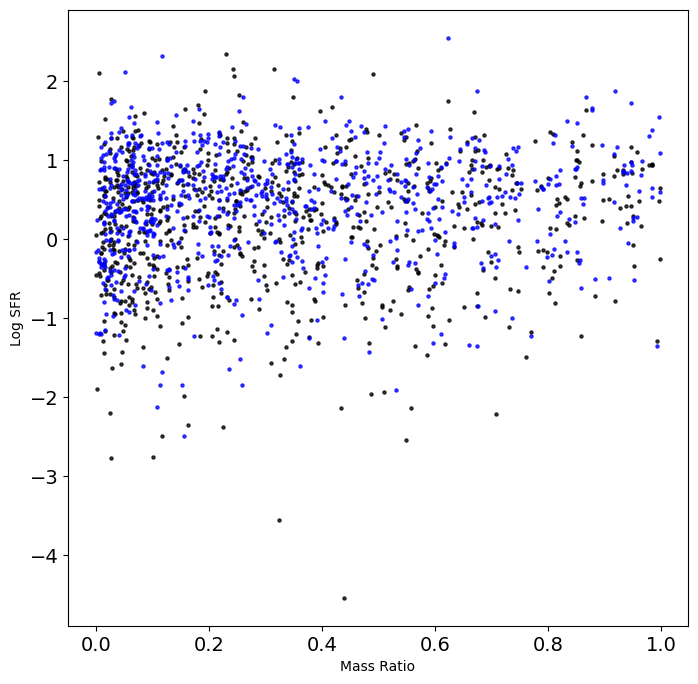

In [44]:
fig, ax = plt.subplots(figsize = (8,8))
df_ratios.plot.scatter(
    x = 'mr',
    y = 'ez_sfr_prim',
    s = 5,
    alpha = 0.75,
    ax = ax,
    color = 'black'
)
df_ratios.plot.scatter(
    x = 'mr',
    y = 'ez_sfr_sec',
    s = 5,
    alpha = 0.75,
    ax = ax,
    color = 'blue',
    xlabel = 'Mass Ratio',
    ylabel = 'Log SFR',
    fontsize = 14
)
plt.show()

In [54]:
def add_logs(logx1, logx2):
    x1 = 10**logx1
    x2 = 10**logx2
    x = x1 + x2
    return x

In [55]:
df_ratios_tot = (
    df_ratios
    .assign(sfr_tot = df_ratios.apply(lambda row: add_logs(row.ez_sfr_prim, row.ez_sfr_sec), axis = 1))
)

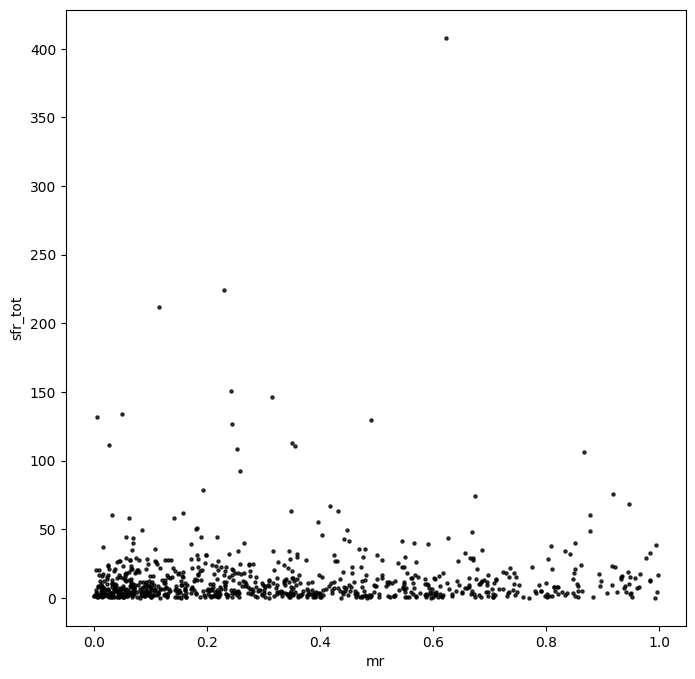

In [56]:
fig, ax = plt.subplots(figsize = (8,8))
df_ratios_tot.plot.scatter(
    x = 'mr',
    y = 'sfr_tot',
    s = 5,
    alpha = 0.75,
    ax = ax,
    color = 'black'
)
plt.show()

### Mass Ratio with Stage

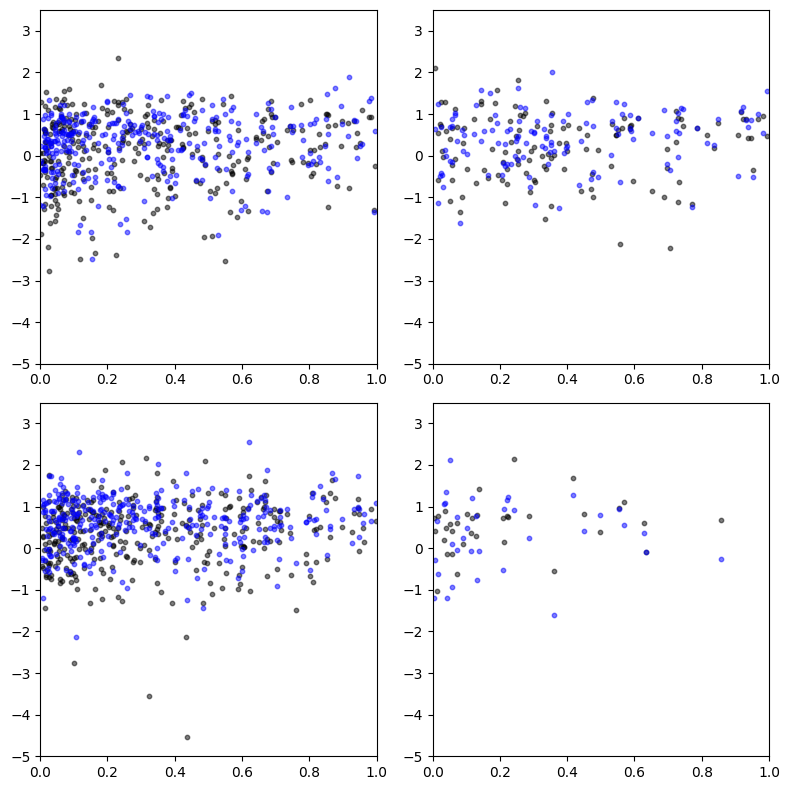

In [57]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))
counter = 1
for i in range(2):
    for j in range(2):
        df_stage = df_ratios.query(f'prim_cat == "stage{counter}"')
        df_stage.plot.scatter(
            x = 'mr',
            y = 'ez_sfr_prim',
            s = 10,
            alpha = 0.5,
            color = 'black',
            ax = ax[i,j],
            xlabel = '',
            ylabel = ''
        )
        df_stage.plot.scatter(
            x = 'mr',
            y = 'ez_sfr_sec',
            s = 10,
            alpha = 0.5,
            color = 'blue',
            ax = ax[i,j],
            xlabel = '',
            ylabel = ''
        )
        
        ax[i,j].set_xlim([0,1])
        ax[i,j].set_ylim([-5,3.5])
        
        counter += 1
fig.tight_layout()
plt.show()

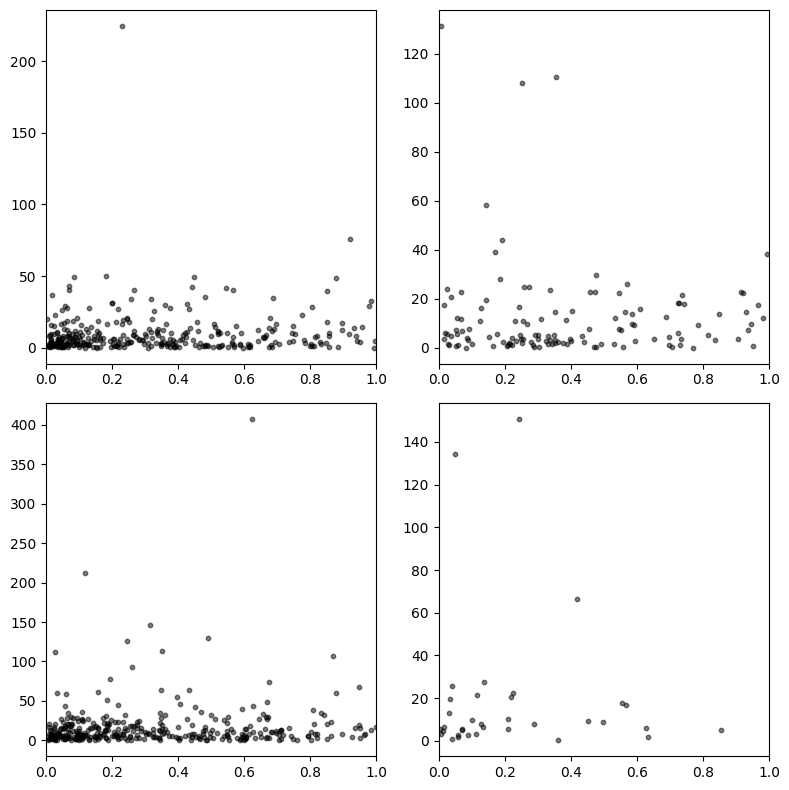

In [59]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))
counter = 1
for i in range(2):
    for j in range(2):
        df_stage = df_ratios_tot.query(f'prim_cat == "stage{counter}"')
        df_stage.plot.scatter(
            x = 'mr',
            y = 'sfr_tot',
            s = 10,
            alpha = 0.5,
            color = 'black',
            ax = ax[i,j],
            xlabel = '',
            ylabel = ''
        )
        
        ax[i,j].set_xlim([0,1])
        # ax[i,j].set_ylim([-5,3.5])
        
        counter += 1
fig.tight_layout()
plt.show()